# New Lockdown Model WIP

In [1]:
import altair as alt
from matplotlib.pylab import plt
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
import matplotlib.dates as mdates



import pandas as pd
import numpy as np

import seaborn as sns
import altair as alt

import datetime 

alt.data_transformers.disable_max_rows()

%matplotlib inline

In [3]:
master_dataset = '../data/processed/master_covid.csv'
lockdown_model_dataset = '../data/processed/lockdown_model.csv'



# The Master Dataset

In [4]:

df = pd.read_csv(master_dataset, parse_dates=['date'])
df.shape

(25272, 90)

In [5]:
df['country'].nunique()

207

In [6]:
min_cases, min_deaths = 100, 20

max_new_cases_for_countries = df.groupby('country')['new_cases_rolling_mean'].sum()
max_new_deaths_for_countries = df.groupby('country')['new_deaths_rolling_mean'].sum()

countries_with_cases = df['country'].isin(max_new_cases_for_countries[max_new_cases_for_countries>min_cases].index)
countries_with_deaths = df['country'].isin(max_new_deaths_for_countries[max_new_deaths_for_countries>min_deaths].index)

df[countries_with_cases].country.nunique(), df[countries_with_deaths].country.nunique()

(172, 123)

In [7]:
# Focus on countries with >1M population
# df = df[df['population']>500000]

# Exclude <0 cases/deaths
check_cols = df.filter(regex='_cases|_deaths').columns

df[check_cols] = df[check_cols].clip(lower=0)

df[check_cols].min()

df.shape, df.country.nunique()

((25272, 90), 207)

# The Lockdown Model

## The Lockdown Stages
The model is based on mobility changes as restrictions are introduced and relaxed, resulting in 3 distinct phases: drop, hold, and bounce.

In [8]:
def get_lockdown_dates(mobility, delta=10):
    """Identify the start dates for the drop, hold, and bounce phases."""

    # The min mobility of the lockdown is the key reference for the stages.
    bottom = mobility.min()
    bottom_date = mobility.idxmin()

    # The hold starts when mobility levels drop below bottom+delta for the first time
    pre_bottom = mobility.loc[:bottom_date]
    hold_start_date = pre_bottom[pre_bottom<bottom+delta].index[0]

    # The drop begins when mobility drops below -delta for the final time (before the bottom)
    # We also need to check whether the drop starts before the dataset in which case mobility 
    # levels may never exceed the -delta
    pre_hold = mobility.loc[:hold_start_date].iloc[::-1]
    drop_threshold = min(-delta, pre_hold.max())
    drop_start_date = pre_hold[pre_hold >= drop_threshold].index[0]

    # The bounce starts the last time that rises above bottom+delta
    post_bottom = mobility.loc[bottom_date:].iloc[::-1]
    bounce_start_date = post_bottom[post_bottom<bottom+delta].index[0] + datetime.timedelta(days=1)

    return drop_start_date, hold_start_date, bounce_start_date


def get_lockdown_stages(mobility):
    """Given a series of mobility levels for a country produce a corresponding series
    of phases, with each date associated with a phase label."""
    
    if len(mobility)>0:
    
        drop_start_date, hold_start_date, bounce_start_date = get_lockdown_dates(mobility)

        # The end dates of the stages
        drop_end_date = hold_start_date-datetime.timedelta(days=1)
        hold_end_date = bounce_start_date-datetime.timedelta(days=1)
        bounce_end_date = mobility.index[-1]

        stages = mobility.copy()
        stages.loc[:drop_start_date] = 'C'
        stages.loc[drop_start_date:drop_end_date] = 'D'
        stages.loc[hold_start_date:hold_end_date] = 'H'
        stages.loc[bounce_start_date:bounce_end_date] = 'B'

        return stages
    

### Label each stage

In [9]:
with_mobility = df['google_rolling_mobility_drop'].notnull()

df[with_mobility].shape, df[with_mobility]['country'].nunique()

((14019, 90), 132)

In [10]:
# Generate the lockdown phases series for each country
lockdown_stages = pd.DataFrame(
    df.groupby('country').apply(
        lambda g: get_lockdown_stages(g.set_index('date')['google_rolling_mobility_drop'].dropna())
    ), columns=['lockdown_stage']).dropna()

# Add these to the main df
df = df.set_index(['country', 'date']).join(lockdown_stages).reset_index()

# Add a dummy lockdown stage instead of Nulls to accommodate future joins.
# df.loc[df['lockdown_stage'].isnull(), 'lockdown_stage'] = 'N'

df.shape

(25272, 91)

### Add a day number for each stage

In [11]:
lockdown_stage_days = pd.DataFrame(
    df.groupby(['country', 'lockdown_stage']).apply(
        lambda g: pd.Series(range(1, len(g)+1), index=g['date'])),
    columns=['lockdown_stage_day']
)   

df = df.set_index(['country', 'lockdown_stage', 'date']).join(lockdown_stage_days).reset_index()
df.shape

(25272, 92)

In [12]:
df.groupby(['continent', 'country', 'lockdown_stage']).size().groupby(['continent', 'lockdown_stage']).mean().unstack()[['D', 'H', 'B']]

lockdown_stage          D          H          B
continent                                      
Africa          10.814815  39.814815  38.333333
Asia            16.735294  36.857143  39.647059
Europe          10.081081  34.648649  52.432432
North America   14.166667  39.368421  40.315789
Oceania         10.500000  22.500000  56.000000
South America    8.400000  43.600000  48.222222

In [13]:
df.groupby(['region', 'country', 'lockdown_stage']).size().groupby(['region', 'lockdown_stage']).mean().unstack()[['D', 'H', 'B']]

lockdown_stage                          D          H          B
region                                                         
andean_republics                 8.800000  54.600000  40.250000
australasia                     11.000000  26.000000  53.000000
caribbean_republics              6.000000  44.000000  45.000000
carribean                       15.250000  31.111111  47.444444
central_africa                  14.333333  34.333333  42.666667
central_america                 13.428571  48.000000  32.285714
central_asia                     9.333333  31.333333  37.000000
east_africa                      9.000000  36.750000  41.875000
east_asia                       10.000000  35.000000  52.500000
eastern_europe                   9.400000  32.400000  52.900000
melanesia_micronesia_polynesia  10.000000  19.000000  59.000000
middle_east                     22.583333  37.666667  32.083333
north_africa                     4.500000  49.000000  38.000000
northern_america                13.000000  44.000000  37.666667
northern_europe                 12.000000  34.555556  51.000000
river_plate_republics            8.500000  29.750000  57.000000
south_asia                      20.833333  35.333333  42.400000
south_east_asia                 15.111111  37.111111  41.777778
southern_africa                 10.000000  30.000000  45.500000
southern_europe                 10.600000  37.200000  51.200000
west_africa                      6.545455  46.727273  35.181818
western_asia                    27.500000  32.000000  36.000000
western_europe                   8.125000  34.375000  55.000000

### Daily rates of increase

In [14]:
daily_rates_of_increase = df.groupby(['country', 'lockdown_stage']).apply(
    lambda g: g.set_index('date')[['total_cases', 'total_deaths', 'rt']].rolling(7, center=True).mean().pct_change().replace([np.inf, -np.inf], np.nan))

df = df.set_index(['country', 'lockdown_stage', 'date']).join(daily_rates_of_increase, rsuffix='_pct_change').reset_index()

df.sample()

country lockdown_stage       date country_id country_code  \
6973  Ecuador              H 2020-05-02         EC          ECU   

          continent  total_cases  new_cases  total_deaths  new_deaths  \
6973  South America      26336.0     1402.0        1063.0       163.0   

          ...        ContainmentHealthIndex  ContainmentHealthIndexForDisplay  \
6973      ...                         90.15                             90.15   

      EconomicSupportIndex  EconomicSupportIndexForDisplay  \
6973                  75.0                            75.0   

      apple_mobility_drop  apple_rolling_mobility_drop  lockdown_stage_day  \
6973                  NaN                          NaN                41.0   

      total_cases_pct_change  total_deaths_pct_change  rt_pct_change  
6973                0.047887                 0.123855       0.014489  

[1 rows x 95 columns]

# Save Lockdown Model

In [16]:
df.to_csv(lockdown_model_dataset, index=False)
df.shape, lockdown_model_dataset

((25272, 95), '../data/processed/lockdown_model.csv')

In [17]:
assert False

AssertionError: 

# The Extended Peak Model
This is a model of daily numbers growth (cases, deaths etc). It works by tracking daily numbers relative to the current peak and then assigns stage labels to these numbers based on how daily values varey with respect to the peak. The model assumes that numbers transition through the following key stages:

* Incubation (I) - 0 < daily < delta*peak
* Expenasion (E) - delta*peak < daily < (1-delta)*peak (per peak)
* Peak (P) - (1-delta)*peak < daily < peak
* Contraction (C) - (1-delta)*peak < daily < delta*peak (post peak)
* Stable (S) - daily < (1-delta)*peak (post peak)

In this work delta=0.125 so that the peak stages correspond with colour transitions based on the %peak values.

There are a few complications when it coems to calculating these stages:

* To be confident that we have found the peak, there must be at least 10 days of contraction, otherwise we assume that we are still in the expansion stage.
* The contraction stage finishes on the last day that teh daily numbers fall below delta*peak; in other words, during contraction the daily numbers may oscillate around the delta*peak threshold for some time and it is only once the consistently fall below it that we can justify the end of the contraction stage. Of course, if we have only a few days of stable numbers then it is possible in the future that the end of teh contraction stage will need to be revised, if a future day exceeds the delta*peak threshold once more.
* In a similar fashion, the peak stage ends when the daily numbers drop below (1-delta)*peak and never return above it. Thus, during the peak stage, the daily numbers may oscilate around this (1-delta)*peak threshold until the finally fall below it, never to return.



## The Growth Stages – Expansion, Peak, Contraction


In [143]:
# The peak model transition colours
transition_colours = ['green', 'yellow', 'orange', 'red']

# The delta camn be calculated based on the number of transitions
# and adjusted so that it corresponds to the colour change transitions
# in the peak model.
peak_delta = 1/(2*len(transition_colours))

min_contraction_days = 10

peak_delta

0.125

### Calculating the Stage Transitions

In [144]:

def get_growth_model_dates(s, delta=peak_delta):
    """Identify the peak start and end dates; s is date indexed."""
    
    # The peak and peak date
    peak, peak_date = s.max(), s.idxmax()
    
    # pre and post peak
    pre, post = s.loc[:peak_date], s.loc[peak_date:].iloc[1:].iloc[::-1]  
   
    # The expansion starts when pre>delta*peak;
    expansion = pre[pre>delta*peak]
    expansion_start_date = expansion.index[0] if len(expansion)>0 else s.index[0]
    
    # The incubation stage starts when pre>0
    incubation = pre[pre>0]
    incubation_start_date = incubation.index[0] if len(incubation)>0 else False
    
    # The contraction ends on the last day where post>delta*peak
    contraction = post[post>delta*peak]
    contraction_end_date = contraction.index[0] if len(contraction)>0 else False
    
    # The stable stage starts after the contraction end date if there are days available.
    if contraction_end_date:
        stable_end_date =  s.index[-1] if (contraction_end_date < s.index[-1]) else False
    else:
        stable_end_date = False
    
    # The peak ends when post rises above (1-delta)*peak for the last time.
    peak_end = post[post>(1-delta)*peak]
    
    # If we have found the peak end...
    if len(peak_end)>0:
        peak_end_date = peak_end.index[0]
        
    # Else if there are post days but none are above the peak thershold
    # then it must mean that numbers dropped below teh peak on the day after
    # the peak
    elif len(post)>0:
        peak_end_date = post.index[-1]
    else:
        peak_end_date = False
            

    # The peak is only valid if the current date is > min_contraction_days beyond the end of the peak. 
    if (peak_end_date is False):
    
        # No end peak was located
        return incubation_start_date, expansion_start_date, s.index[-1],s.index[-1], False, False, False
    
    elif (s.index[-1]-peak_end_date).days < min_contraction_days:
        
        # And end peak was located but its too close to the current date to be certain.
        return incubation_start_date, expansion_start_date, s.index[-1], s.index[-1], False, False, False
        
        
    # Otherwise peak is valid so find the start of the peak stage and finish.
    else:
        # The peak stage starts after the expansion and when pre>(1-delta)*peak before the peak date
        pre = pre.loc[expansion_start_date:]  # Reverse pre to be right way round.
        peak_start = pre[pre>(1-delta)*peak]

        peak_start_date = peak_start.index[0] if len(peak_start)>0 else False
    
        return incubation_start_date, expansion_start_date, peak_date, peak_start_date, peak_end_date, contraction_end_date, stable_end_date


def get_growth_model_stages(s):
    
    if len(s)>0:
                
        stages = pd.Series([np.nan]*len(s), index=s.index)
        
        stage_dates = get_growth_model_dates(s)
                
        incubation_start_date, expansion_start_date, peak_date, peak_start_date, peak_end_date, contraction_end_date, stable_end_date = stage_dates
        
        if incubation_start_date:
            stages.loc[incubation_start_date: expansion_start_date] = 'I'
        
        if peak_start_date:
            expansion_end_date = peak_start_date - datetime.timedelta(days=1)
            stages.loc[expansion_start_date:expansion_end_date] = 'E'
            
            if peak_end_date:
                contraction_start_date = peak_end_date + datetime.timedelta(days=1)
                stages.loc[peak_start_date:peak_end_date] = 'P'
                stages.loc[contraction_start_date:] = 'C'
            
            else:
                stages.loc[peak_start_date:] = 'P'
                
        if stable_end_date:
            stages.loc[contraction_end_date: stable_end_date] = 'S'

        return stages

### Assigning the Stages

In [145]:
def assign_growth_stages(df, col, groupby):
    
    growth_stage_col = 'growth_stage'+'_'+col
    
    # Generate the lockdown phases series for each country
    growth_stages = pd.DataFrame(
        df.groupby(groupby).apply(
            lambda g: get_growth_model_stages(g.set_index('date')[col].dropna())
        ), columns=[growth_stage_col]
    )
    
    df = df.set_index([groupby, 'date']).join(growth_stages).reset_index()
        
    # Add stage days
    growth_stage_days = pd.DataFrame(
        df.groupby([groupby, growth_stage_col]).apply(
            lambda g: pd.Series(range(1, len(g)+1), index=g['date'])),
        columns=[growth_stage_col+'_day']
    )
    
    return df.set_index([groupby, growth_stage_col, 'date']).join(growth_stage_days).reset_index()
    
    
    

In [146]:
df = assign_growth_stages(df, 'new_cases_rolling_mean', 'country')
df = assign_growth_stages(df, 'new_deaths_rolling_mean', 'country')

df.tail()

country growth_stage_new_deaths_rolling_mean       date  \
25267  Zimbabwe                                    E 2020-06-19   
25268  Zimbabwe                                    E 2020-06-20   
25269  Zimbabwe                                    E 2020-06-21   
25270  Zimbabwe                                    E 2020-06-22   
25271  Zimbabwe                                    P 2020-06-23   

      growth_stage_new_cases_rolling_mean lockdown_stage country_id  \
25267                                   E              B         ZW   
25268                                   E            NaN         ZW   
25269                                   E            NaN         ZW   
25270                                   E            NaN         ZW   
25271                                   P            NaN         ZW   

      country_code continent  total_cases  new_cases  \
25267          ZWE    Africa        463.0       62.0   
25268          ZWE    Africa        479.0       16.0   
25269          ZWE    Africa        486.0        7.0   
25270          ZWE    Africa        489.0        3.0   
25271          ZWE    Africa        512.0       23.0   

                         ...                     EconomicSupportIndex  \
25267                    ...                                      NaN   
25268                    ...                                      NaN   
25269                    ...                                      NaN   
25270                    ...                                      NaN   
25271                    ...                                      NaN   

       EconomicSupportIndexForDisplay  apple_mobility_drop  \
25267                            25.0                  NaN   
25268                             NaN                  NaN   
25269                             NaN                  NaN   
25270                             NaN                  NaN   
25271                             NaN                  NaN   

       apple_rolling_mobility_drop  lockdown_stage_day  \
25267                          NaN                56.0   
25268                          NaN                 NaN   
25269                          NaN                 NaN   
25270                          NaN                 NaN   
25271                          NaN                 NaN   

       total_cases_pct_change  total_deaths_pct_change  rt_pct_change  \
25267                     0.0                      0.0            NaN   
25268                     NaN                      NaN            NaN   
25269                     NaN                      NaN            NaN   
25270                     NaN                      NaN            NaN   
25271                     NaN                      NaN            NaN   

       growth_stage_new_cases_rolling_mean_day  \
25267                                     23.0   
25268                                     24.0   
25269                                     25.0   
25270                                     26.0   
25271                                      1.0   

       growth_stage_new_deaths_rolling_mean_day  
25267                                      85.0  
25268                                      86.0  
25269                                      87.0  
25270                                      88.0  
25271                                       1.0  

[5 rows x 99 columns]

## Build Growth Models for Continents & Regions

### Summary by Continent

In [147]:
# growth_cols = ['total_cases', 'new_cases_rolling_mean', 'total_deaths', 'new_deaths_rolling_mean', 'population']

# df_continents = df.groupby(['continent', 'date'])[growth_cols].sum().reset_index()

# df_continents['total_cases_per_million'] = 1000000*df_continents['total_cases']/df_continents['population']
# df_continents['total_deaths_per_million'] = 1000000*df_continents['total_deaths']/df_continents['population']

# df_continents['new_cases_per_million_rolling_mean'] = 1000000*df_continents['new_cases_rolling_mean']/df_continents['population']
# df_continents['new_deaths_per_million_rolling_mean'] = 1000000*df_continents['new_deaths_rolling_mean']/df_continents['population']

# df_continents.tail()

### Summary by Region

In [148]:
# df_regions = df.groupby(['region', 'date'])[growth_cols].sum().reset_index()

# df_regions['total_cases_per_million'] = 1000000*df_regions['total_cases']/df_regions['population']
# df_regions['total_deaths_per_million'] = 1000000*df_regions['total_deaths']/df_regions['population']

# df_regions['new_cases_per_million_rolling_mean'] = 1000000*df_regions['new_cases_rolling_mean']/df_regions['population']
# df_regions['new_deaths_per_million_rolling_mean'] = 1000000*df_regions['new_deaths_rolling_mean']/df_regions['population']

# df_regions.tail()

# Visualising Growth Models

## Plotting Single Growth Models

In [149]:
cmap = mcolors.LinearSegmentedColormap.from_list("", transition_colours)

def plot_ext_peak_model(ax, data, stages=None, cmap=cmap, show_landmarks=True, title=None):
    """Plot a single growth model based on date indexed data and stages."""
    
    # Calculate the max and relative data
    peak, peak_date, total = data.max(), data.idxmax(), data.sum()
    rel = data/peak
    
    # The start and end date of the graph
    start, end = datetime.date(2020, 1, 1), datetime.date.today()
    
    # The colour map to use.
    colours = [cmap(v) for v in rel.values]

    # Plot the coloured bar chart and the outline line.
    ax.bar(rel.index, rel, color=colours, width=1)
    ax.plot(rel.index, rel, lw=1, c='k')
    
    if show_landmarks:
        
        # Add the growth stages
        stage_start_dates = stages.reset_index().groupby(
            stages.reset_index().columns[1]).first().reindex(['E', 'P', 'C', 'S']).dropna()

        stage_start_dates['date'].map(
            lambda start_date: ax.plot([start_date]*2,[0, 1], lw=1, ls='--', c='k'))

        ax.axhline(1, lw=1, c='k')

        ax.axhline(peak_delta, lw=1, ls='--', c='k')
        ax.axhline(1-peak_delta, lw=1, ls='--', c='k')
        
        # The duration of the peak = days between peak start and contraction start.
        days_since_peak = (datetime.datetime.today()-peak_date).days
        if 'C' in stage_start_dates.index:
            peak_duration = pd.to_timedelta(stage_start_dates.loc['C'].values[0]-stage_start_dates.loc['P'].values[0]).days
            peak_text = '{}d, {}d ago'.format(peak_duration, days_since_peak)
        else:
            peak_text = 'current, {}d ago'.format(days_since_peak)
        
    else:         
        ax.axis('off')
        
    if title is not None:
        peak_value = '{}k'.format(round(peak/1000, 1)) if peak>999 else '{}'.format(int(peak))
        ax.set_title(
            '{}\nPeak ~{} ({})\nTotal ~{:,}'.format(title, peak_value, peak_text, int(total)), 
            loc='left', ha='left')

    # Finalise the axes.
    ax.set_xlim(start, end)
    ax.set_ylim(0, 1.2)
    ax.set_yticks(np.arange(0, 1.1, .5))
    
    # x-axis date locators and formatters
    locator = mdates.AutoDateLocator(maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)

    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    month_fmt = mdates.DateFormatter('%b')
    def m_fmt(x, pos=None):
        return month_fmt(x)[:1]

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(FuncFormatter(m_fmt))
    
    return peak, peak_date






In [150]:
def plot_ext_peak_model_for_group(ax, data, col, cmap=cmap, show_landmarks=True, title=None):
    
    """Plot a single growth model for a collection of data."""
    
    summed_data = data.groupby('date')[col].sum()
    
    growth_stages = get_growth_model_stages(summed_data)
    
    plot_ext_peak_model(ax, summed_data, growth_stages, show_landmarks=show_landmarks, title=title)
    
    return summed_data.max(), summed_data.idxmax(), summed_data.sum(), 



### Global Cases

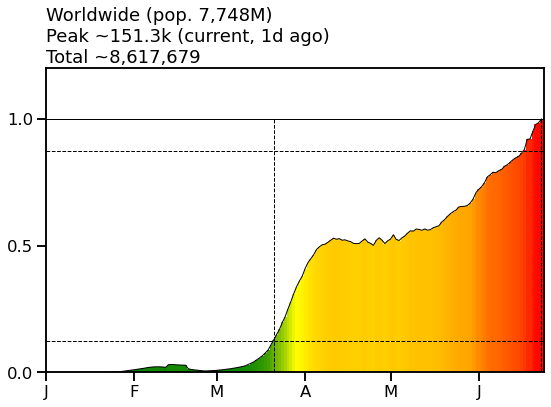

In [163]:
fig, ax = plt.subplots(figsize=(8, 6))

data = df
col = 'new_cases_rolling_mean'

title = 'Worldwide (pop. {:,}M)'.format(int(data.groupby('country').first().population.sum()/1000000))
peak, peak_date, total = plot_ext_peak_model_for_group(ax, data, col, cmap=cmap, show_landmarks=True, title=title)

fig.tight_layout()

### European Cases

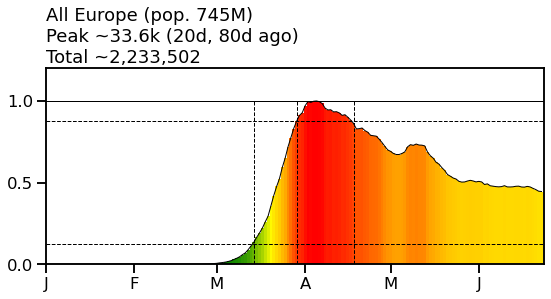

In [162]:
sns.set_context('talk')

fig, ax = plt.subplots(figsize=(8, 4.5))

data = df[df['continent']=='Europe']
col = 'new_cases_rolling_mean'

title = 'All Europe (pop. {:,}M)'.format(int(data.groupby('country').first().population.sum()//1000000))
plot_ext_peak_model_for_group(ax, data, col, cmap=cmap, show_landmarks=True, title=title)

fig.tight_layout()

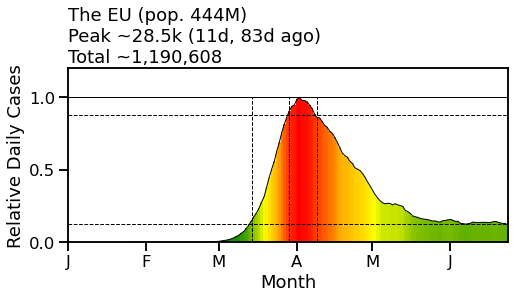

In [161]:
eu = [
    'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 
    'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 
    'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 
    'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 
    'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden'
]

sns.set_context('talk')

fig, ax = plt.subplots(figsize=(7.5, 4.5))


data = df[df['country'].isin(eu)]
col = 'new_cases_rolling_mean'

title = 'The EU (pop. {:,}M)'.format(int(data.groupby('country').first().population.sum()//1000000))
plot_ext_peak_model_for_group(ax, data, col, cmap=cmap, show_landmarks=True, title=title)

ax.set_ylabel('Relative Daily Cases')
ax.set_xlabel('Month')

fig.tight_layout()

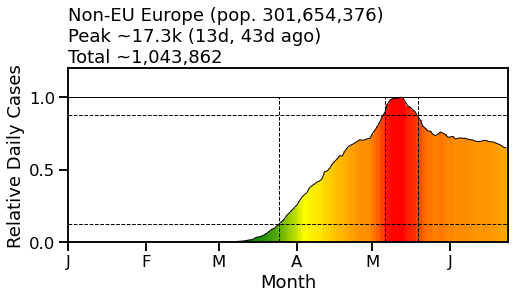

In [154]:
sns.set_context('talk')

fig, ax = plt.subplots(figsize=(7.5, 4.5))


data = df[(df['continent']=='Europe') & (~df['country'].isin(eu))]
col = 'new_cases_rolling_mean'

title = 'Non-EU Europe (pop. {:,})'.format(int(data.groupby('country').first().population.sum()))
plot_ext_peak_model_for_group(ax, data, col, cmap=cmap, show_landmarks=True, title=title)

ax.set_ylabel('Relative Daily Cases')
ax.set_xlabel('Month')

fig.tight_layout()

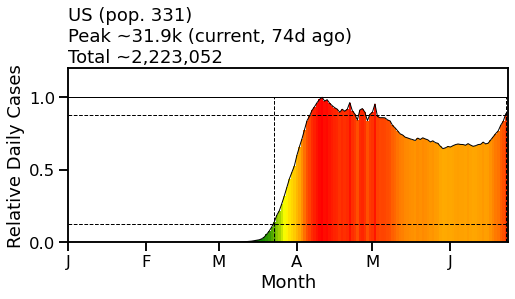

In [164]:
sns.set_context('talk')

fig, ax = plt.subplots(figsize=(7.5, 4.5))

data = df[df['country']=='United States']
col = 'new_cases_rolling_mean'

title = 'US (pop. {:,})'.format(int(data.groupby('country').first().population.sum()//1000000))
plot_ext_peak_model_for_group(ax, data, col, cmap=cmap, show_landmarks=True, title=title)

ax.set_ylabel('Relative Daily Cases')
ax.set_xlabel('Month')

fig.tight_layout()


## A bar grid of growth models by continent

In [156]:

def plot_bar_grid(df, x_col, y_col, value_col, cmap=cmap, w=2, h=2):
    
    growth_stage_col = 'growth_stage_'+value_col
    
    num_cols = df[x_col].nunique()
    num_rows = df.groupby(x_col)[y_col].nunique().max()
            
    # Sort rows by peak date; need to aggregate by dates first in case of groups of countries.
    peak_dates = df.groupby([x_col, y_col, 'date']).apply(
        lambda g: g.set_index('date')[[value_col]].sum()).reset_index().groupby([x_col, y_col]).apply(
            lambda g: g.set_index('date')[value_col].idxmax()).map(
                lambda dt: (datetime.datetime(2020, 1, 1)-dt).days).groupby(x_col).mean()    
    
    sorted_cols = sorted(df[x_col].unique(), key=lambda x: peak_dates.loc[x], reverse=True)

    fig, axs = plt.subplots(
        figsize=(w*num_cols, h*num_rows), ncols=num_cols, nrows=num_rows,
        gridspec_kw={'hspace': 0.75,},
        sharex=True, sharey=True
    )

    # Turn all graph frames off
    for row_num in range(num_rows): 
        for col_num in range(num_cols): 
            axs[row_num, col_num].axis('off')

    for col_num, col_name in enumerate(sorted_cols):
                
        row_names = df[df[x_col]==col_name][y_col].unique()

        sum_values = df[df[x_col]==col_name].groupby(y_col)[value_col].sum()
        sorted_rows = sorted(row_names, key=lambda y: sum_values.loc[y], reverse=True)

        for row_num, row_name in enumerate(sorted_rows):
            
            print(col_name, row_name)

            rev_row = (num_rows-1) - row_num
                      
            # The data for the current graph
            data = df[(df[x_col]==col_name) & (df[y_col]==row_name)].set_index('date')
                        
            # Construct the graph title
            max_chars = 18
            title = row_name.replace('_', ' ').title()
            short_title = title if len(title)<max_chars else title[:max_chars]+'…'
            short_title = '{} ({:,}M)'.format(short_title, int(data.groupby('country').first().population.sum())//1000000)
            
            # Plot the graph
            plot_ext_peak_model_for_group(axs[rev_row, col_num], data, value_col, cmap=cmap, show_landmarks=True, title=short_title)
            
            # Add axis border and ticks
            axs[rev_row, col_num].axis('on')
            axs[rev_row, col_num].tick_params(axis=u'both', which=u'both',length=0)
            
    # Add the column labels
    for i, name in enumerate(sorted_cols):
        axs[num_rows-1, i].set_xlabel(name.replace('_', ' ').title(), fontsize=20)
        
    print('Finished')
        
    return fig, axs
        




/Users/barrysmyth/anaconda/envs/htw/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4315: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_values = np.vstack(map(np.asarray, values))


Oceania australasia
Oceania melanesia_micronesia_polynesia
Europe eastern_europe
Europe southern_europe
Europe western_europe
Europe northern_europe
Asia south_asia
Asia middle_east
Asia western_asia
Asia south_east_asia
Asia east_asia
Asia central_asia
Africa southern_africa
Africa west_africa
Africa middle_east
Africa north_africa
Africa central_africa
Africa east_africa
South America river_plate_republics
South America andean_republics
South America caribbean_republics 
North America northern_america
North America central_america
North America carribean
Finished


/Users/barrysmyth/anaconda/envs/htw/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  import sys


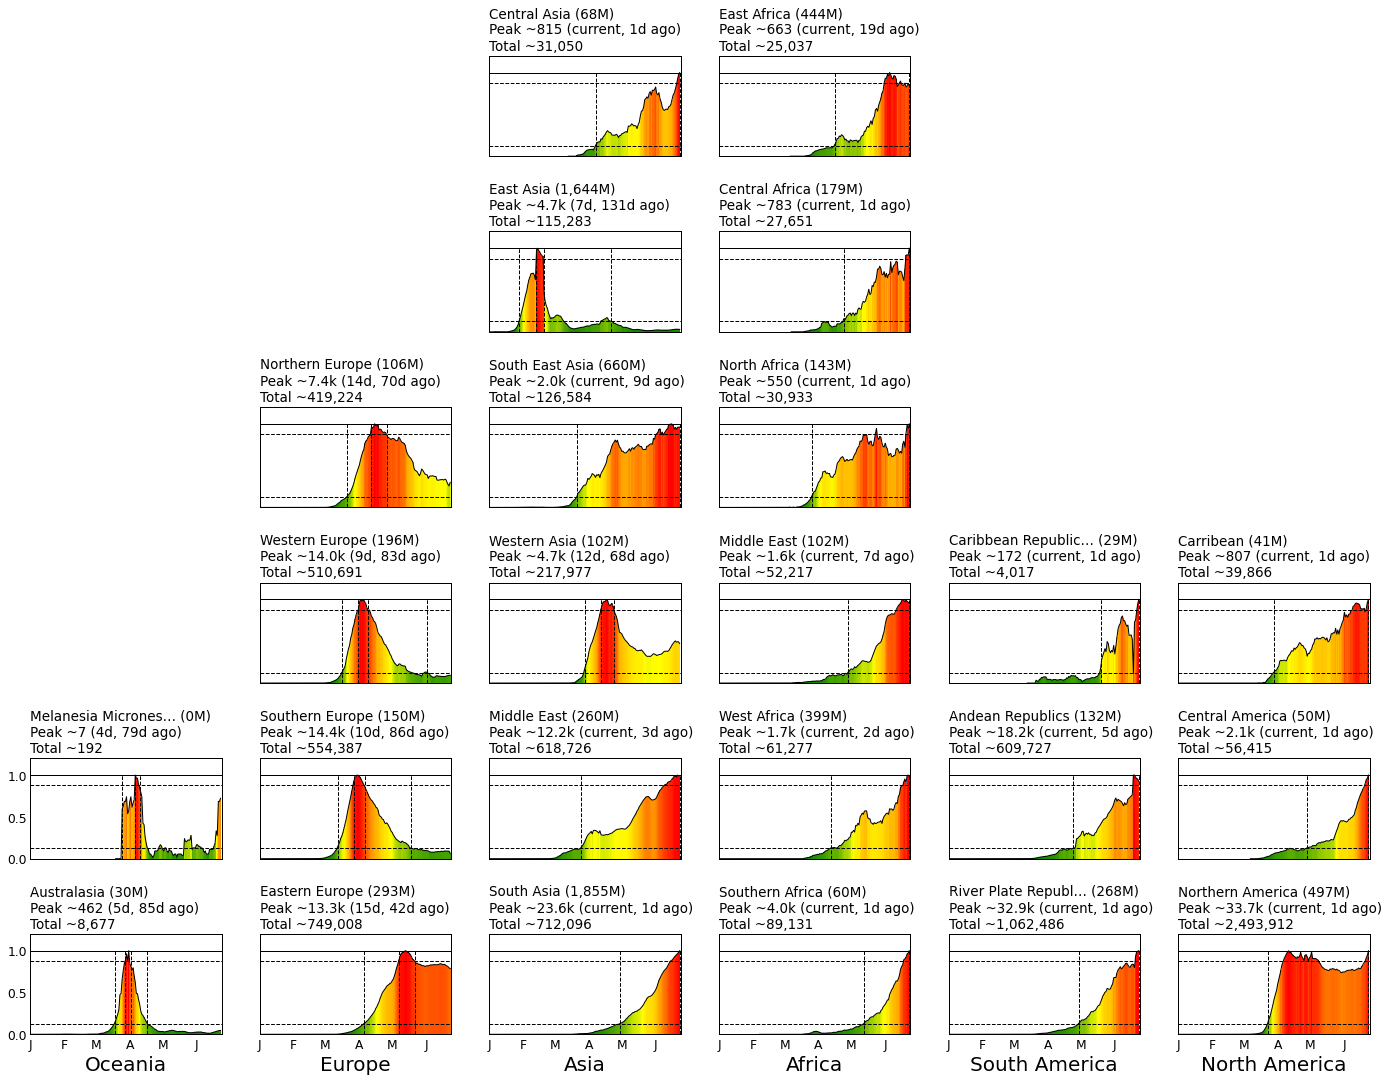

In [157]:
sns.set_context('paper', font_scale=1.4)

w, h = 4, 3

fig, axs = plot_bar_grid(df[countries_with_cases], 'continent', 'region', 'new_cases_rolling_mean', cmap=cmap, w=w, h=h)

fig.tight_layout()

fig.savefig('../graphs/continents_by_regions_bar_grid_cases.png', dpi=300, format='png')

/Users/barrysmyth/anaconda/envs/htw/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4315: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_values = np.vstack(map(np.asarray, values))


Oceania australasia
Europe southern_europe
Europe western_europe
Europe northern_europe
Europe eastern_europe
North America northern_america
North America central_america
North America carribean
Asia south_asia
Asia middle_east
Asia east_asia
Asia western_asia
Asia south_east_asia
Asia central_asia
Africa middle_east
Africa southern_africa
Africa north_africa
Africa west_africa
Africa central_africa
Africa east_africa
South America river_plate_republics
South America andean_republics
South America caribbean_republics 
Finished


/Users/barrysmyth/anaconda/envs/htw/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  import sys


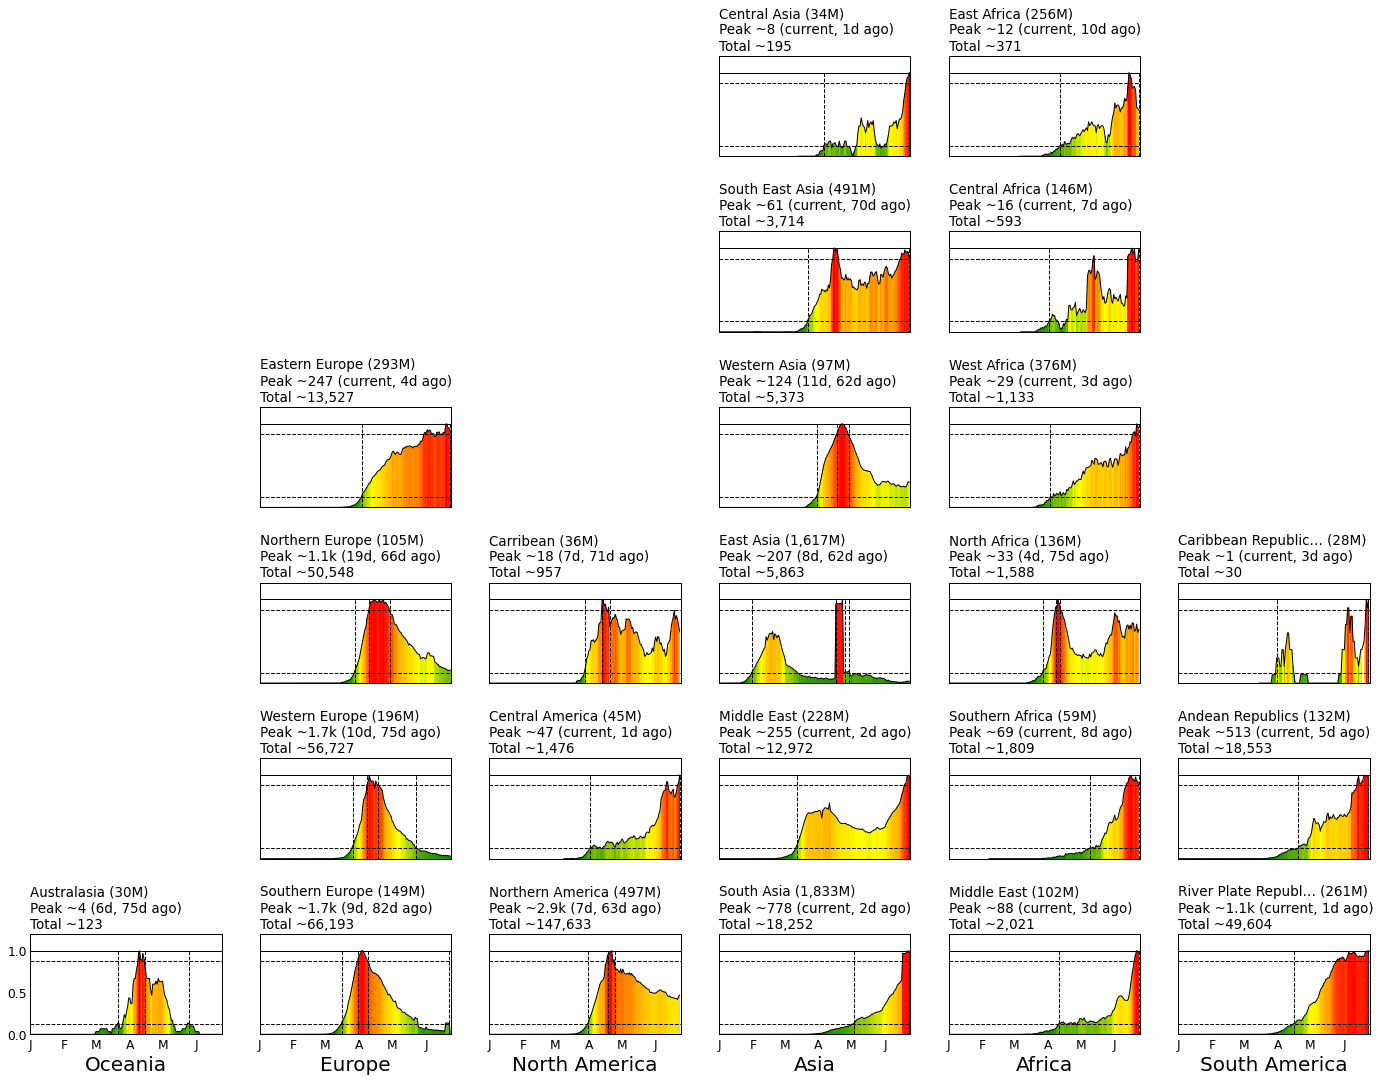

In [158]:
sns.set_context('paper', font_scale=1.4)

w, h = 4, 3

fig, axs = plot_bar_grid(df[countries_with_deaths], 'continent', 'region', 'new_deaths_rolling_mean', cmap=cmap, w=w, h=h)

fig.tight_layout()

fig.savefig('../graphs/continents_by_regions_bar_grid_deaths.png', dpi=300, format='png')

/Users/barrysmyth/anaconda/envs/htw/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4315: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_values = np.vstack(map(np.asarray, values))


east_asia China
east_asia Japan
east_asia South Korea
east_asia Taiwan
east_asia Mongolia
australasia Australia
australasia New Zealand
western_europe Germany
western_europe France
western_europe Belgium
western_europe Netherlands
western_europe Switzerland
western_europe Austria
western_europe Luxembourg
melanesia_micronesia_polynesia Guam
northern_europe United Kingdom
northern_europe Sweden
northern_europe Ireland
northern_europe Denmark
northern_europe Norway
northern_europe Finland
northern_europe Estonia
northern_europe Lithuania
northern_europe Iceland
northern_europe Latvia
northern_europe Isle of Man
northern_europe Jersey
northern_europe Guernsey
northern_europe Faeroe Islands
south_east_asia Indonesia
south_east_asia Singapore
south_east_asia Philippines
south_east_asia Malaysia
south_east_asia Thailand
south_east_asia Vietnam
south_east_asia Myanmar
south_east_asia Cambodia
south_east_asia Brunei
southern_europe Spain
southern_europe Italy
southern_europe Portugal
southern_

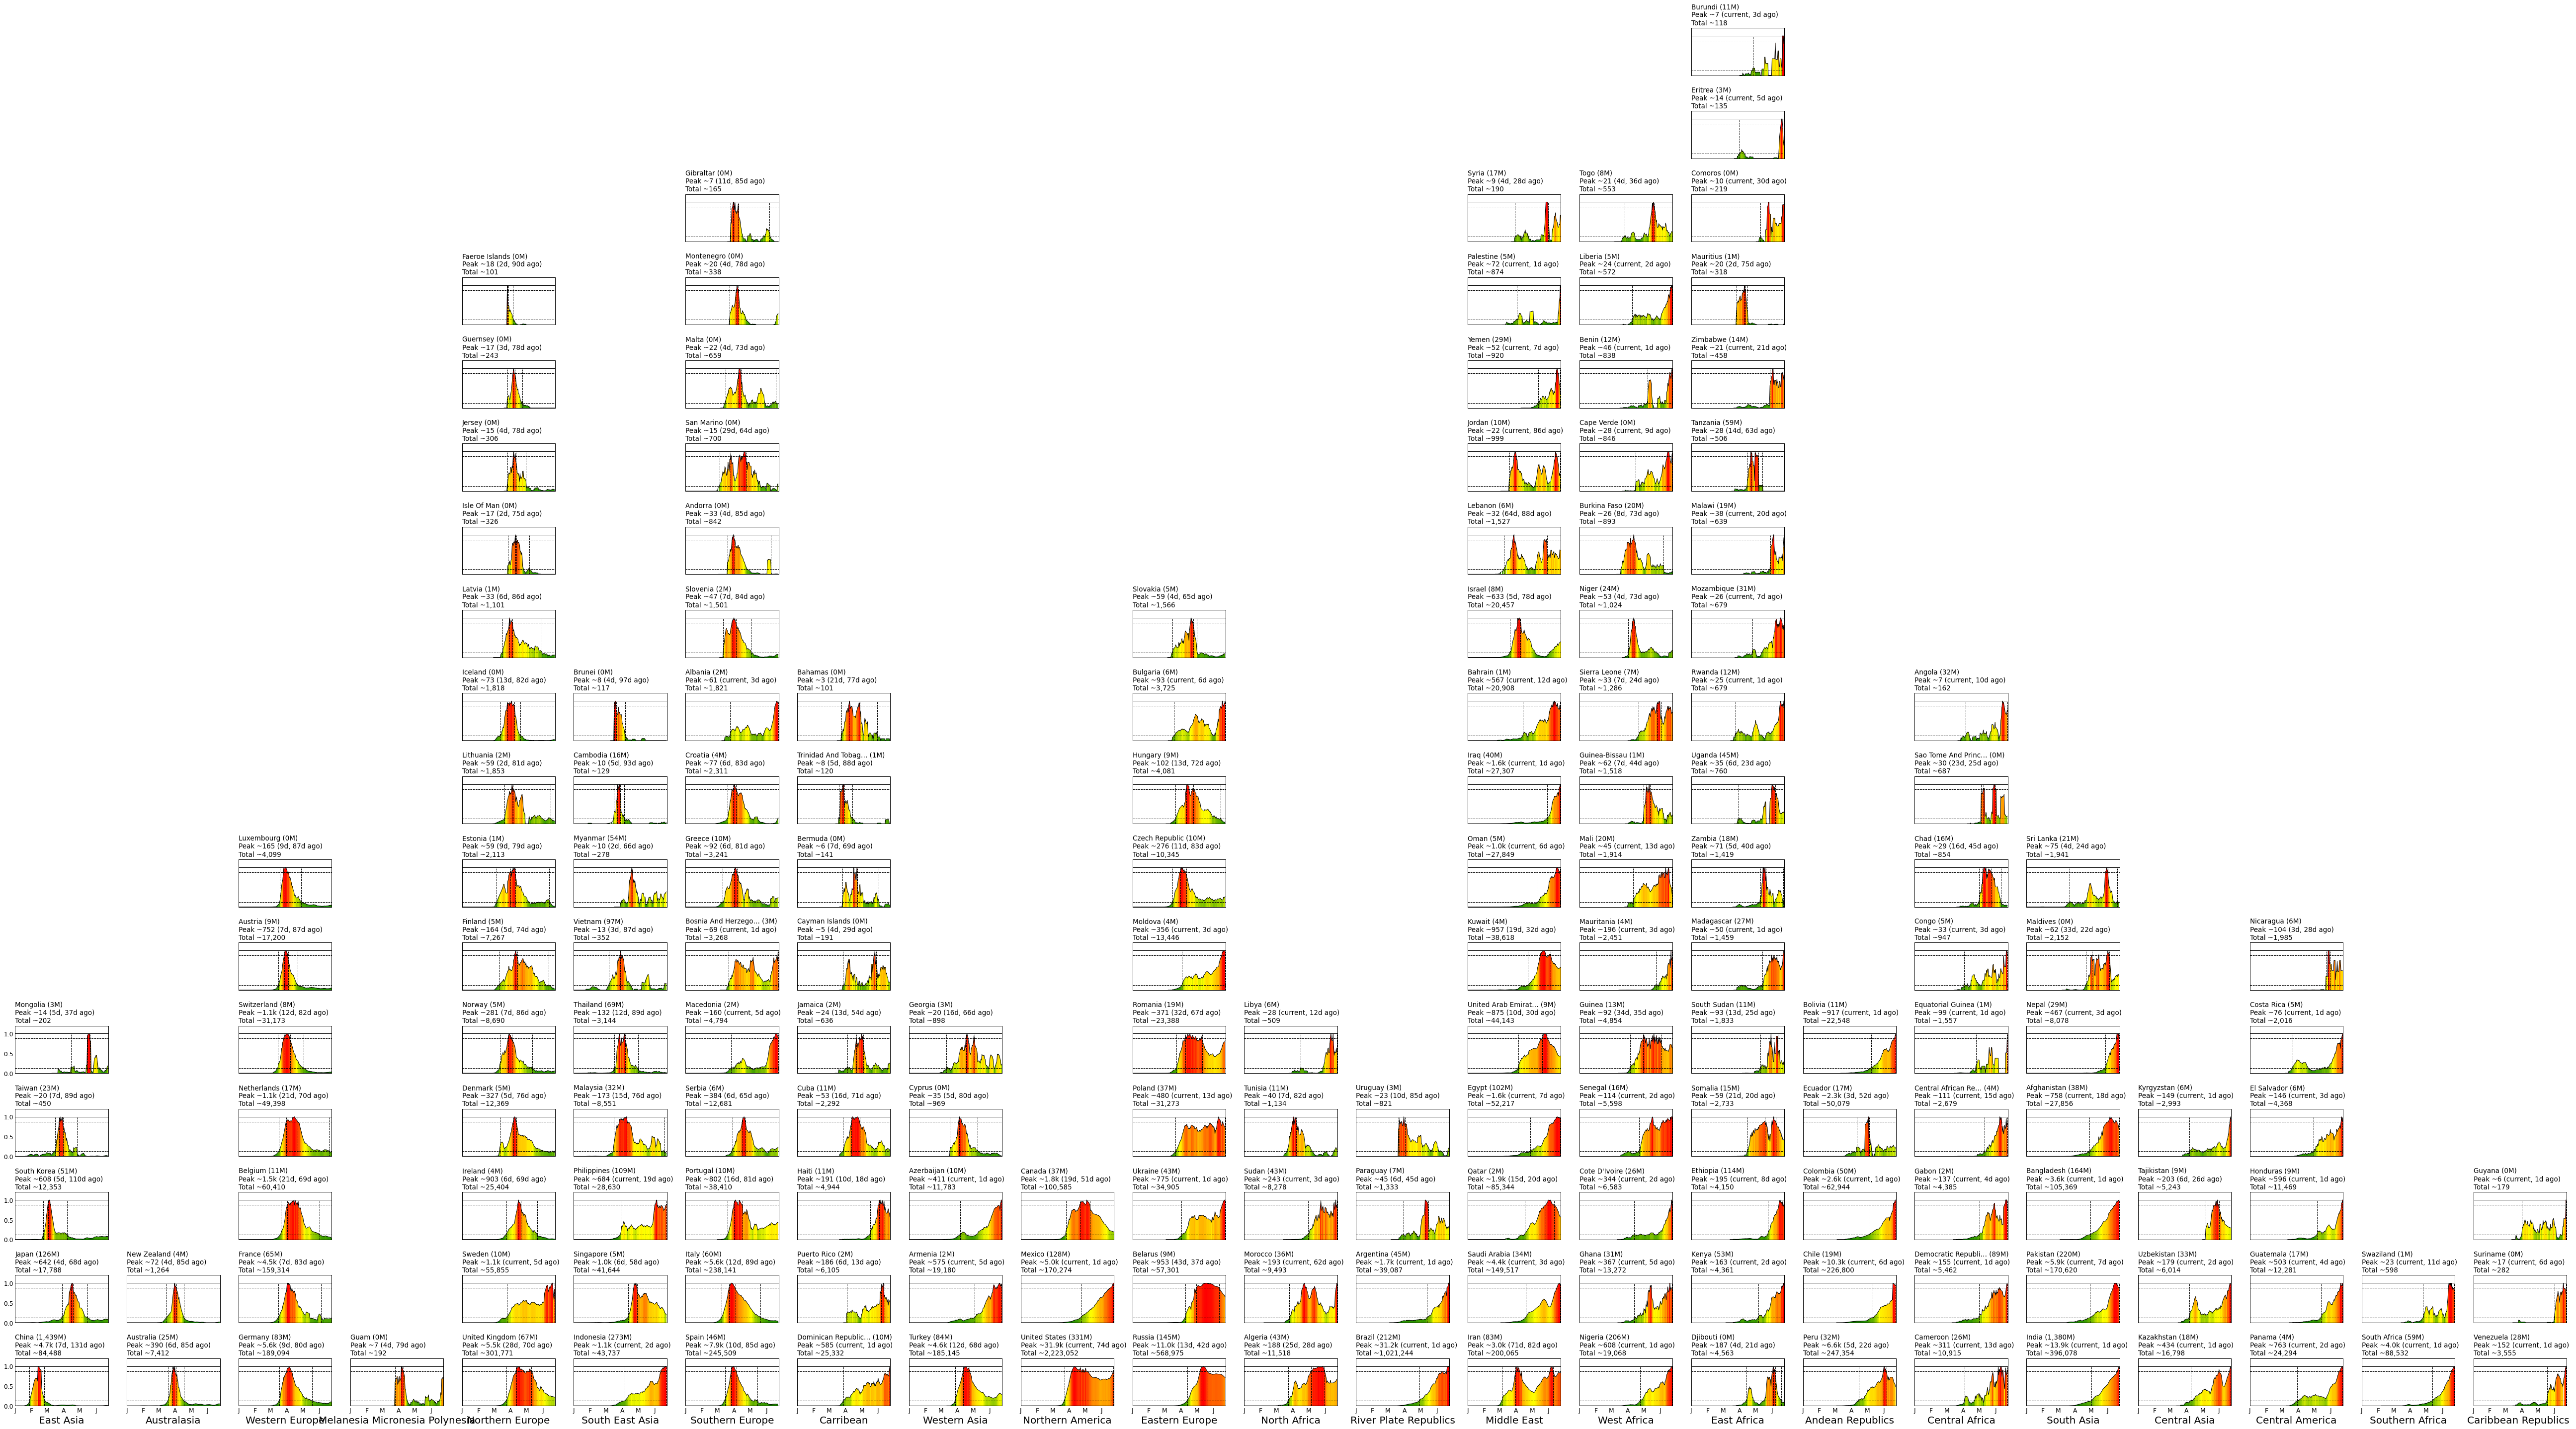

In [159]:
sns.set_context('paper', font_scale=1.4)

fig, axs = plot_bar_grid(df[countries_with_cases], 'region', 'country', 'new_cases_rolling_mean', cmap=cmap, w=w, h=h)

print('here')

# fig.tight_layout()

fig.savefig('../graphs/regions_by_countries_bar_grid_cases.png', dpi=200, format='png')

/Users/barrysmyth/anaconda/envs/htw/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4315: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_values = np.vstack(map(np.asarray, values))


western_europe France
western_europe Belgium
western_europe Germany
western_europe Netherlands
western_europe Switzerland
western_europe Austria
western_europe Luxembourg
australasia Australia
australasia New Zealand
east_asia China
east_asia Japan
east_asia South Korea
southern_europe Italy
southern_europe Spain
southern_europe Portugal
southern_europe Serbia
southern_europe Macedonia
southern_europe Greece
southern_europe Bosnia and Herzegovina
southern_europe Slovenia
southern_europe Croatia
southern_europe Andorra
southern_europe San Marino
southern_europe Albania
northern_europe United Kingdom
northern_europe Sweden
northern_europe Ireland
northern_europe Denmark
northern_europe Finland
northern_europe Norway
northern_europe Lithuania
northern_europe Estonia
northern_europe Jersey
northern_europe Latvia
northern_europe Isle of Man
north_africa Algeria
north_africa Sudan
north_africa Morocco
north_africa Tunisia
south_east_asia Indonesia
south_east_asia Philippines
south_east_asia 

/Users/barrysmyth/anaconda/envs/htw/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  import sys


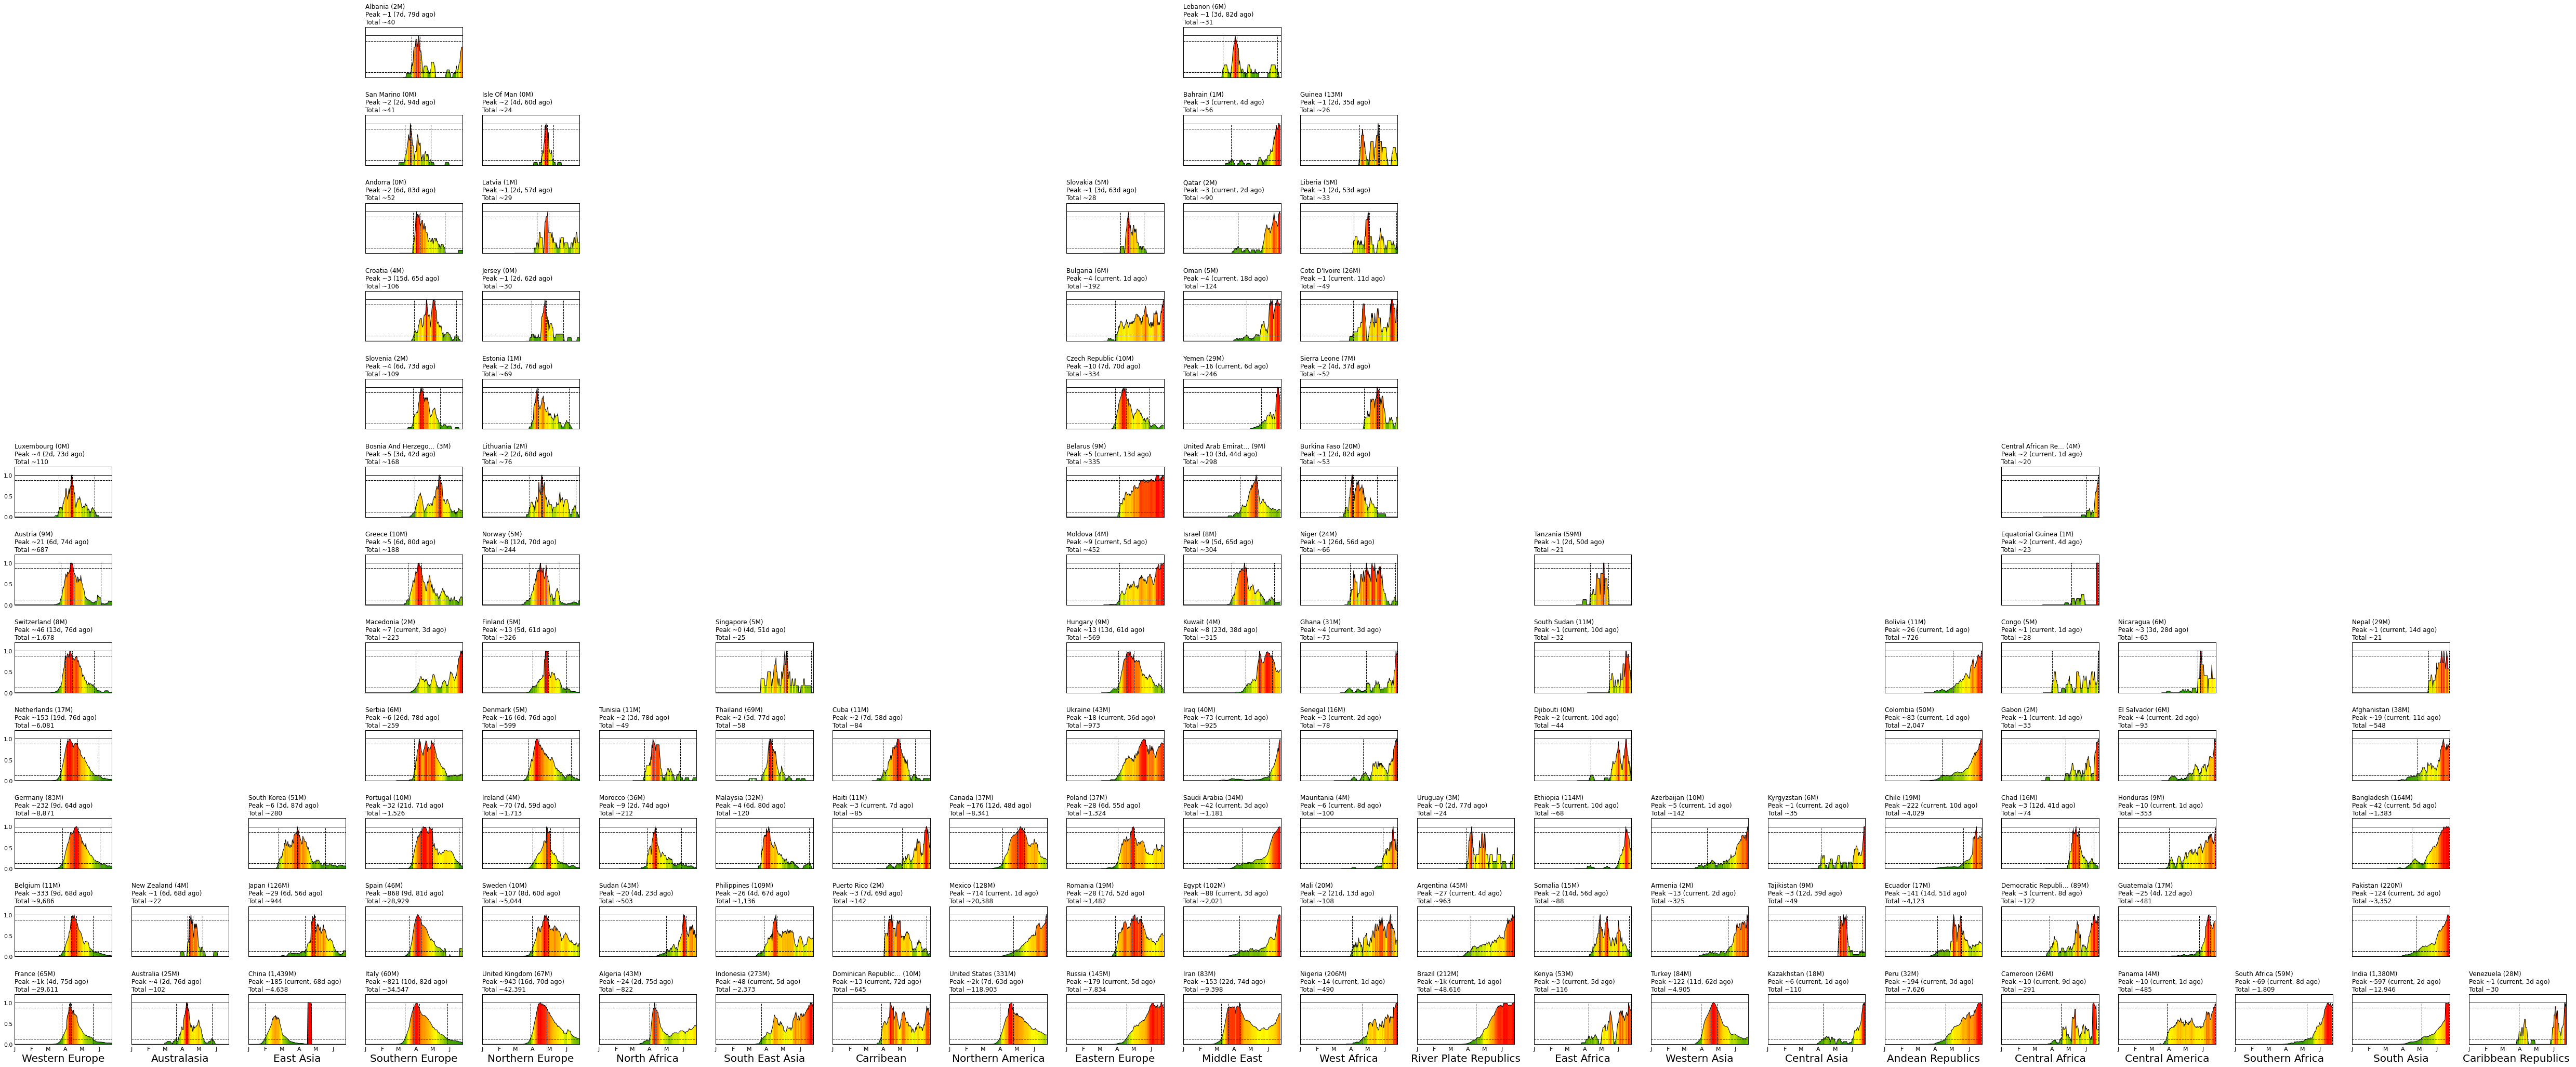

In [30]:
sns.set_context('paper', font_scale=1.25)

fig, axs = plot_bar_grid(df[countries_with_deaths], 'region', 'country', 'new_deaths_rolling_mean', cmap=cmap, w=w, h=h)

print('here')

fig.tight_layout()

fig.savefig('../graphs/regions_by_countries_bar_grid_deaths.png', dpi=300, format='png')

/Users/barrysmyth/anaconda/envs/htw/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4315: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_values = np.vstack(map(np.asarray, values))


Oceania Australia
Oceania New Zealand
Europe Russia
Europe United Kingdom
Europe Spain
Europe Italy
Europe Germany
Europe France
Europe Belgium
Europe Belarus
Europe Sweden
Europe Netherlands
Europe Portugal
Europe Ukraine
Europe Poland
Europe Switzerland
Europe Ireland
Europe Romania
Europe Austria
Europe Moldova
Europe Serbia
Europe Denmark
Europe Czech Republic
Europe Norway
Europe Finland
Europe Macedonia
Europe Luxembourg
Europe Hungary
Europe Bulgaria
Europe Bosnia and Herzegovina
Europe Greece
Europe Croatia
Europe Estonia
Europe Lithuania
Europe Albania
Europe Iceland
Europe Slovakia
Europe Slovenia
Europe Latvia
Europe Andorra
Europe San Marino
Europe Malta
Asia India
Asia Iran
Asia Turkey
Asia Pakistan
Asia Saudi Arabia
Asia Bangladesh
Asia Qatar
Asia China
Asia United Arab Emirates
Asia Indonesia
Asia Singapore
Asia Kuwait
Asia Philippines
Asia Afghanistan
Asia Oman
Asia Iraq
Asia Bahrain
Asia Israel
Asia Armenia
Asia Japan
Asia Kazakhstan
Asia South Korea
Asia Azerbaijan
As

/Users/barrysmyth/anaconda/envs/htw/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  """


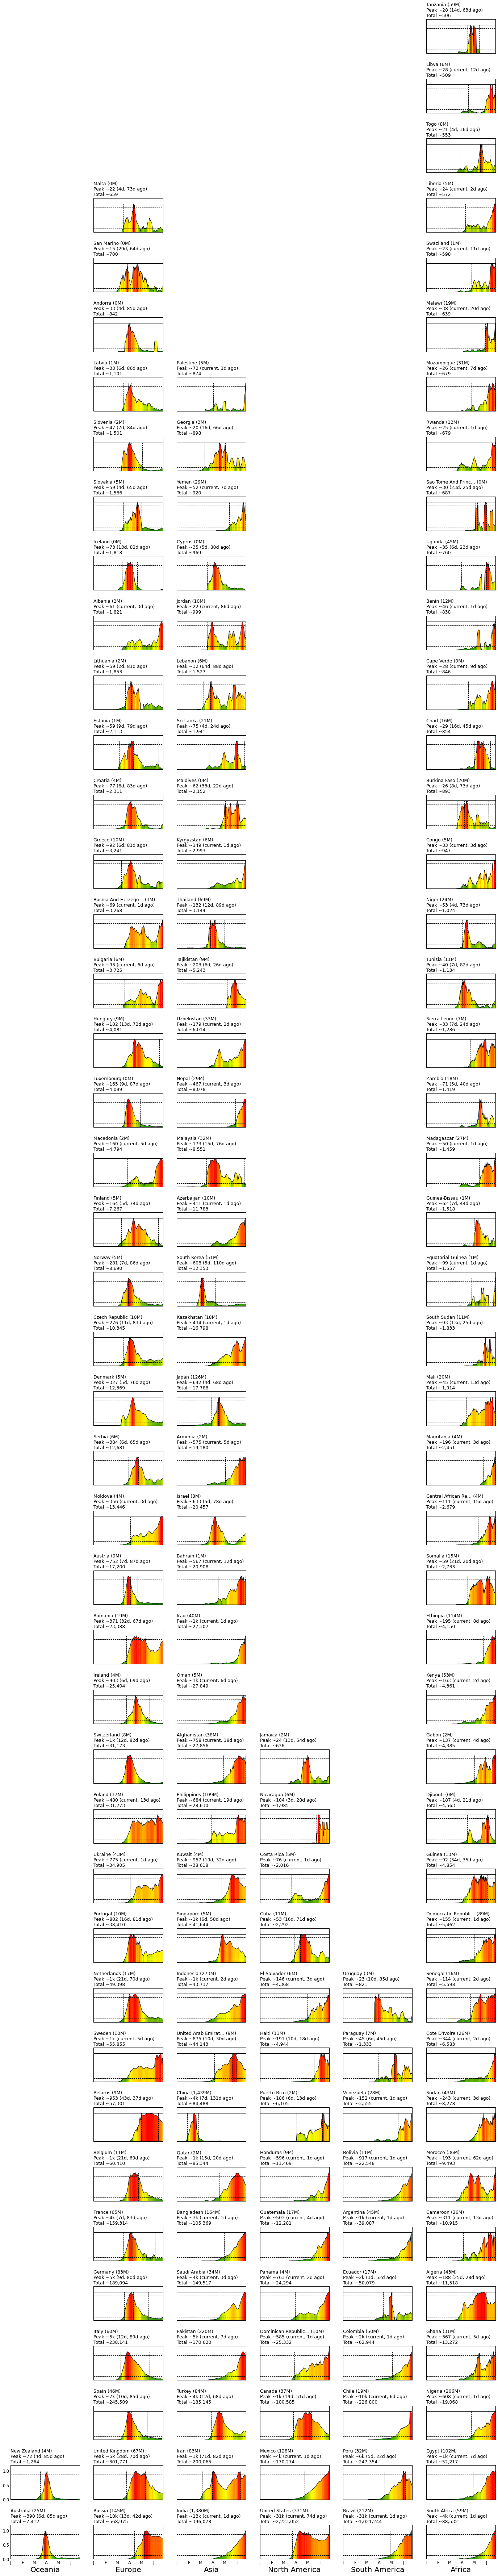

In [31]:
sns.set_context('paper', font_scale=1.3)

fig, axs = plot_bar_grid(df[countries_with_cases], 'continent', 'country', 'new_cases_rolling_mean', cmap=cmap, w=w, h=h)

fig.tight_layout()

fig.savefig('../graphs/continents_by_countries_bar_grid_cases.png', dpi=300, format='png')

/Users/barrysmyth/anaconda/envs/htw/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4315: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_values = np.vstack(map(np.asarray, values))


Oceania Australia
Oceania New Zealand
Europe United Kingdom
Europe Italy
Europe France
Europe Spain
Europe Belgium
Europe Germany
Europe Russia
Europe Netherlands
Europe Sweden
Europe Ireland
Europe Switzerland
Europe Portugal
Europe Romania
Europe Poland
Europe Ukraine
Europe Austria
Europe Denmark
Europe Hungary
Europe Moldova
Europe Belarus
Europe Czech Republic
Europe Finland
Europe Serbia
Europe Norway
Europe Macedonia
Europe Bulgaria
Europe Greece
Europe Bosnia and Herzegovina
Europe Luxembourg
Europe Slovenia
Europe Croatia
Europe Lithuania
Europe Estonia
Europe Andorra
Europe San Marino
Europe Albania
Europe Jersey
Europe Latvia
Europe Slovakia
Europe Isle of Man
Asia India
Asia Iran
Asia Turkey
Asia China
Asia Pakistan
Asia Indonesia
Asia Bangladesh
Asia Saudi Arabia
Asia Philippines
Asia Japan
Asia Iraq
Asia Afghanistan
Asia Armenia
Asia Kuwait
Asia Israel
Asia United Arab Emirates
Asia South Korea
Asia Yemen
Asia Azerbaijan
Asia Oman
Asia Malaysia
Asia Kazakhstan
Asia Qatar


/Users/barrysmyth/anaconda/envs/htw/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  """


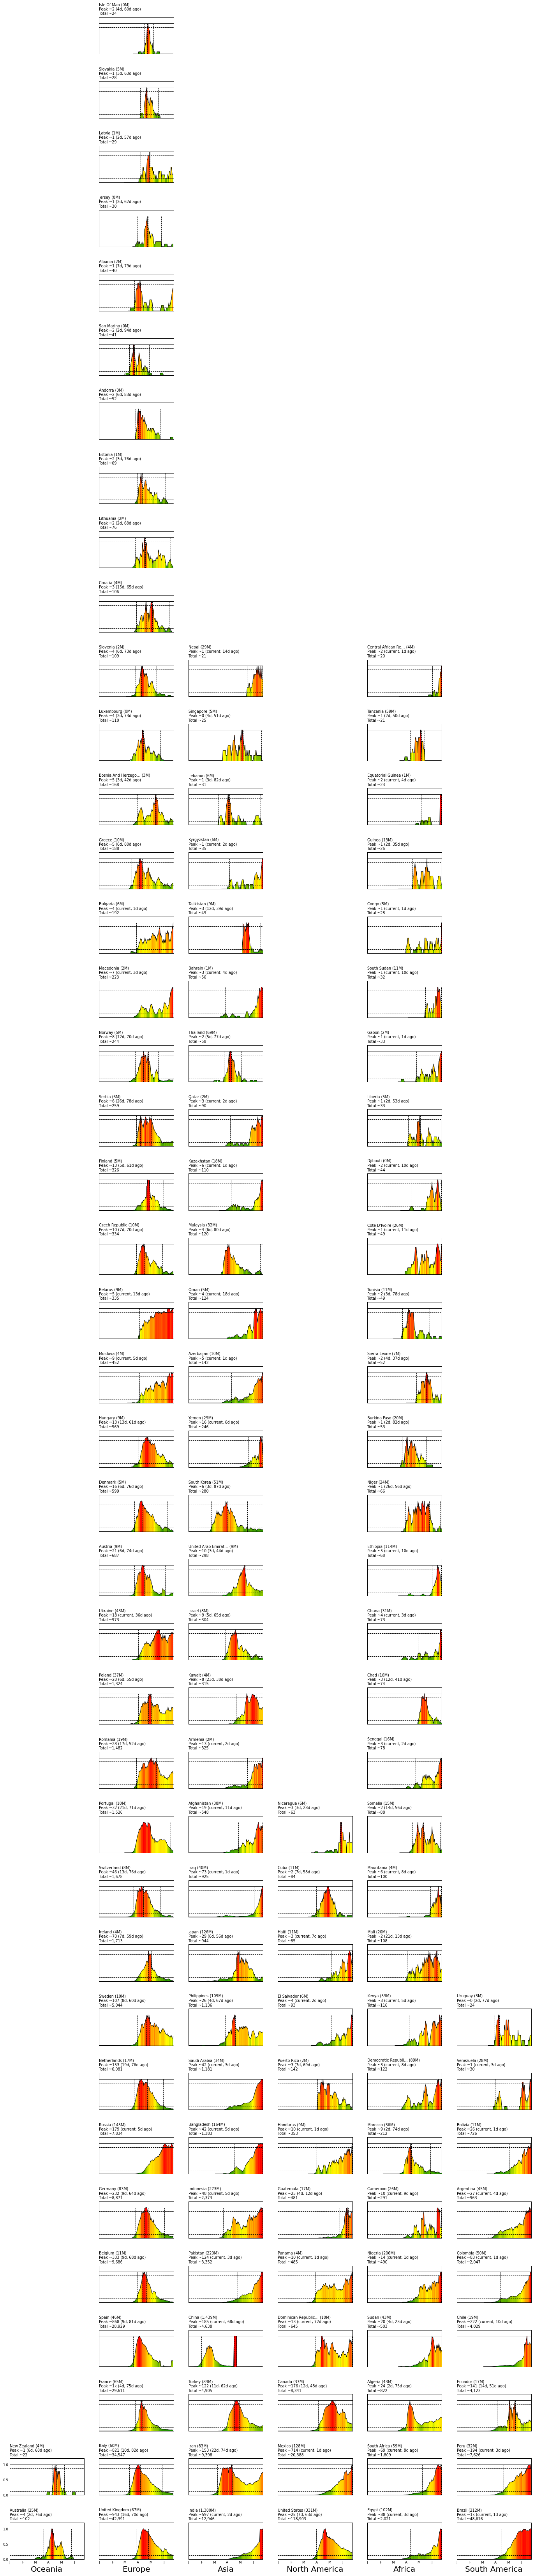

In [32]:
sns.set_context('paper', font_scale=1)

fig, axs = plot_bar_grid(df[countries_with_deaths], 'continent', 'country', 'new_deaths_rolling_mean', cmap=cmap, w=w, h=h)

fig.tight_layout()

fig.savefig('../graphs/continents_by_countries_bar_grid_deaths.png', dpi=300, format='png')

In [33]:
df[df['region']=='northern_europe']['country'].unique()

array(['Denmark', 'Estonia', 'Faeroe Islands', 'Finland', 'Guernsey',
       'Iceland', 'Ireland', 'Isle of Man', 'Jersey', 'Latvia',
       'Lithuania', 'Norway', 'Sweden', 'United Kingdom'], dtype=object)

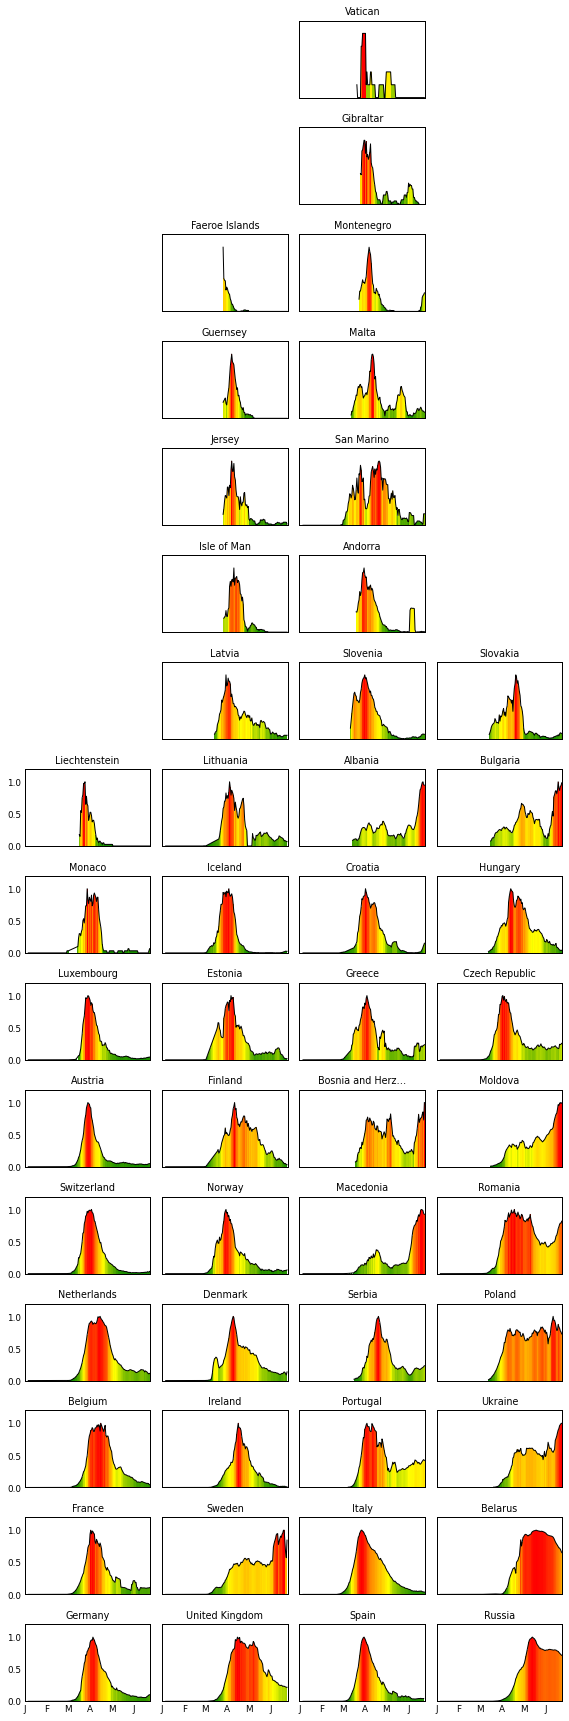

In [34]:
continents = ['Europe']

ddf = df[df['continent'].isin(continents)]  #df[df['region'].isin(['east_africa', 'southern_africa', 'oceania', 'south_america', 'north_america', 'middle_east'])]

num_regions = ddf['region'].nunique()
max_countries = ddf.groupby('region')['country'].nunique().max()

w, h = 2, 1.5

peak_date_per_region = ddf.groupby(['region', 'country']).apply(lambda g: g.set_index('date')['new_cases_rolling_mean'].idxmax()).map(
    lambda dt: (datetime.datetime(2020, 1, 1)-dt).days).groupby('region').mean()
duration_cases_per_region = ddf.groupby(['region', 'country']).size().groupby('region').mean()

sorted_rows = sorted(ddf['region'].unique(), key=lambda region: peak_date_per_region.loc[region], reverse=True)

values_col = 'new_cases_rolling_mean'
growth_stage_col = 'growth_stage_'+values_col


fig, axs = plt.subplots(figsize=(w*num_regions, h*max_countries), ncols=num_regions, nrows=max_countries, sharex=True, sharey=True)

# Turn all graph frames off
for row in range(num_regions):
    for col in range(max_countries):
        axs[col, row].axis('off')
        

for row, region in enumerate(sorted_rows):
    
    countries = ddf[ddf['region']==region]['country'].unique()
    
    total_cases_per_country = ddf[ddf['region']==region].groupby('country')['total_cases'].max()
    sorted_cols = sorted(countries, key=lambda country: total_cases_per_country.loc[country], reverse=True)

    for col, country in enumerate(sorted_cols):
                
        rev_col = (max_countries-1) - col
                
        data = ddf[ddf['country']==country].set_index('date')
        plot_ext_peak_model(axs[rev_col, row], data[values_col], data[growth_stage_col], show_landmarks=False)
        
        max_chars = 15
        short_title = country if len(country)<max_chars else country[:max_chars]+'…'
        axs[rev_col, row].set_title(short_title)
        
        axs[rev_col, row].axis('on')
        axs[rev_col, row].tick_params(axis=u'both', which=u'both',length=0)
        


fig.tight_layout()

fig.savefig('../graphs/growth_models_grid_{}.png'.format('_'.join(continents)), dpi=600, format='png')

## Summarising Growth Models

In [35]:
epcs_colours = ['orange', 'red', 'yellow', 'green']

#### Actual Growth Days
For each continent/country we calculate the number of days in each growth stage; we drop the I stage.

In [36]:
growth_stages = ['I', 'E', 'P', 'C', 'S']

def get_growth_stage_days(df, col='growth_stage_new_cases_rolling_mean'):

    growth_stage_days = df.groupby(['continent', 'region', 'country', col]).size().unstack()[growth_stages].fillna(0)

    growth_stage_days = growth_stage_days.drop(labels=['I'], axis=1)

    return growth_stage_days

get_growth_stage_days(df).head()

growth_stage_new_cases_rolling_mean                   E     P     C     S
continent region         country                                         
Africa    central_africa Angola                    78.0   1.0   0.0   0.0
                         Cameroon                  80.0   1.0   0.0   0.0
                         Central African Republic  43.0   1.0   0.0   0.0
                         Chad                       7.0  16.0  18.0  13.0
                         Congo                     81.0   1.0   0.0   0.0

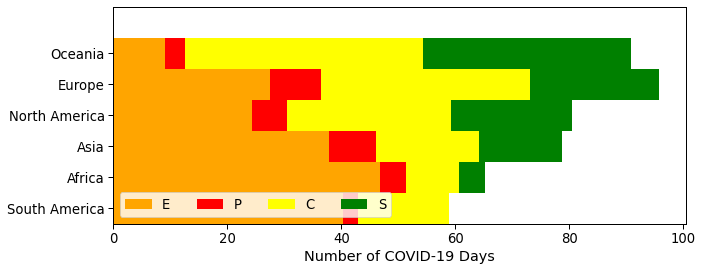

In [37]:
sns.set_context('paper', font_scale=1.5)

epcs_colours = ['orange', 'red', 'yellow', 'green']

fig, ax = plt.subplots(figsize=(10, 4))

get_growth_stage_days(df).groupby('continent').mean().sort_values(by=['S', 'C', 'E'], ascending=True).plot(
        kind='barh', stacked=True,ax=ax, width=1, color=epcs_colours)

ax.set_ylim(-.5, 6.5)
# ax.set_xlim(0, 1)

ax.legend(ncol=5, loc='lower left')

ax.set_ylabel('')
ax.set_xlabel('Number of COVID-19 Days')

fig.tight_layout()

#### Relative Growth Days
A relative version of growth days per stage.

In [38]:
get_growth_stage_days(df).apply(lambda x: x/x.sum(), axis=1).head()

growth_stage_new_cases_rolling_mean                       E         P  \
continent region         country                                        
Africa    central_africa Angola                    0.987342  0.012658   
                         Cameroon                  0.987654  0.012346   
                         Central African Republic  0.977273  0.022727   
                         Chad                      0.129630  0.296296   
                         Congo                     0.987805  0.012195   

growth_stage_new_cases_rolling_mean                       C         S  
continent region         country                                       
Africa    central_africa Angola                    0.000000  0.000000  
                         Cameroon                  0.000000  0.000000  
                         Central African Republic  0.000000  0.000000  
                         Chad                      0.333333  0.240741  
                         Congo                     0.000000  0.000000

In [39]:
def get_growth_stage_status(df, col='growth_stage_new_cases_rolling_mean'):
    
    # Get the growth stages
    growth_stage_days = get_growth_stage_days(df, col='growth_stage_new_cases_rolling_mean')
                 
    # The growth stage rules
    peaked = (growth_stage_days['C']>0)
    stable = growth_stage_days['S']>0
    contracting = (growth_stage_days['C']>0) & ~stable
    expanding = (growth_stage_days['P']>0) & ~contracting & ~stable
    
    growth_stage_status = pd.concat([peaked, expanding, contracting, stable], axis=1)
    growth_stage_status.columns = ['P', 'E', 'C', 'S']
    
    return growth_stage_status

get_growth_stage_status(df).head()

P      E      C      S
continent region         country                                             
Africa    central_africa Angola                    False   True  False  False
                         Cameroon                  False   True  False  False
                         Central African Republic  False   True  False  False
                         Chad                       True  False  False   True
                         Congo                     False   True  False  False

# Growth Stage RQs

## How many have peaked, stablised etc.

In [40]:
growth_status = get_growth_stage_status(df)

growth_status.mean()

P    0.608696
E    0.381643
C    0.260870
S    0.357488
dtype: float64

In [41]:
growth_status.groupby('continent').mean().sort_values(by='P', ascending=False)

P         E         C         S
continent                                            
Oceania        1.000000  0.000000  0.250000  0.750000
Europe         0.836735  0.163265  0.244898  0.591837
North America  0.777778  0.222222  0.277778  0.500000
Asia           0.574468  0.425532  0.319149  0.255319
South America  0.333333  0.666667  0.333333  0.000000
Africa         0.327273  0.636364  0.200000  0.163636

In [42]:
growth_status.groupby('region').mean().sort_values(by='P', ascending=False)

P         E         C         S
region                                                                
western_europe                  1.000000  0.000000  0.000000  1.000000
east_asia                       1.000000  0.000000  0.200000  0.800000
melanesia_micronesia_polynesia  1.000000  0.000000  0.333333  0.666667
australasia                     1.000000  0.000000  0.000000  1.000000
carribean                       0.960000  0.040000  0.280000  0.680000
northern_europe                 0.928571  0.071429  0.142857  0.785714
south_east_asia                 0.818182  0.181818  0.272727  0.545455
southern_europe                 0.812500  0.187500  0.375000  0.437500
western_asia                    0.600000  0.400000  0.400000  0.200000
eastern_europe                  0.600000  0.400000  0.400000  0.200000
northern_america                0.500000  0.500000  0.250000  0.250000
river_plate_republics           0.500000  0.500000  0.500000  0.000000
middle_east                     0.466667  0.533333  0.466667  0.000000
east_africa                     0.444444  0.555556  0.166667  0.277778
north_africa                    0.400000  0.600000  0.400000  0.000000
andean_republics                0.400000  0.600000  0.400000  0.000000
west_africa                     0.352941  0.588235  0.294118  0.117647
central_america                 0.285714  0.714286  0.285714  0.000000
central_asia                    0.250000  0.750000  0.250000  0.000000
south_asia                      0.250000  0.750000  0.125000  0.125000
central_africa                  0.222222  0.777778  0.111111  0.111111
southern_africa                 0.000000  0.800000  0.000000  0.200000
caribbean_republics             0.000000  1.000000  0.000000  0.000000

## Of those that have peaked, how far off their peak are they?

In [43]:
peaked = growth_status[growth_status['P']]

peaked.head()

P      E      C      S
continent region         country                                         
Africa    central_africa Chad                   True  False  False   True
                         Sao Tome and Principe  True  False   True  False
          east_africa    Djibouti               True  False  False   True
                         Mauritius              True  False  False   True
                         Seychelles             True  False  False   True

### ... in terms of days

In [44]:
growth_stage_days = get_growth_stage_days(df)
mean_post_peak_days = growth_stage_days.loc[peaked.index][['C', 'S']].sum(axis=1)

mean_post_peak_days.mean()

61.785714285714285

In [45]:
mean_post_peak_days.groupby('continent').mean().sort_values(ascending=False)

continent
Oceania          78.250000
Europe           70.731707
North America    64.321429
Asia             57.037037
South America    47.500000
Africa           40.444444
dtype: float64

In [46]:
mean_post_peak_days.groupby('region').mean().sort_values(ascending=False)

region
east_asia                         83.600000
australasia                       82.500000
melanesia_micronesia_polynesia    76.833333
western_europe                    76.000000
southern_europe                   74.923077
south_east_asia                   74.666667
northern_europe                   73.538462
carribean                         65.750000
northern_america                  65.000000
western_asia                      63.000000
river_plate_republics             61.000000
north_africa                      50.500000
eastern_europe                    47.666667
central_america                   46.500000
west_africa                       43.500000
east_africa                       39.000000
andean_republics                  34.000000
middle_east                       28.142857
central_africa                    27.000000
central_asia                      23.000000
south_asia                        20.500000
dtype: float64

### ... and in terms of fraction of peak 

In [47]:
peak = df.set_index(['continent', 'region', 'country']).loc[peaked.index].groupby(['continent', 'region', 'country'])['new_cases_rolling_mean'].max()

current_rel_peak_for_peaked = (df.set_index(['continent', 'region', 'country']).loc[peaked.index].groupby(['continent', 'region', 'country']).last()['new_cases_rolling_mean']/peak).dropna()
current_rel_peak_for_peaked.mean()

0.17415797383387846

In [48]:
current_rel_peak_for_peaked.groupby('continent').mean().sort_values(ascending=False)

continent
South America    0.303245
Asia             0.243321
Africa           0.235500
Europe           0.134927
North America    0.122596
Oceania          0.119694
Name: new_cases_rolling_mean, dtype: float64

In [49]:
current_rel_peak_for_peaked.groupby('region').mean().sort_values(ascending=False)

region
middle_east                       0.584084
eastern_europe                    0.428216
north_africa                      0.423622
west_africa                       0.344801
andean_republics                  0.340109
central_america                   0.335459
central_asia                      0.292340
river_plate_republics             0.266380
south_asia                        0.218430
western_asia                      0.171809
melanesia_micronesia_polynesia    0.148148
east_africa                       0.136317
southern_europe                   0.135816
central_africa                    0.116210
carribean                         0.106796
northern_america                  0.099325
south_east_asia                   0.097387
east_asia                         0.071995
western_europe                    0.061919
northern_europe                   0.049219
australasia                       0.034332
Name: new_cases_rolling_mean, dtype: float64

## Likewise for those that are contracting but not yet stable

In [50]:
contracting = growth_status[growth_status['C']]
contracting.head()

P      E     C      S
continent region         country                                        
Africa    central_africa Sao Tome and Principe  True  False  True  False
          east_africa    Somalia                True  False  True  False
                         South Sudan            True  False  True  False
                         Uganda                 True  False  True  False
          north_africa   Algeria                True  False  True  False

### How many contracting days?

In [51]:
mean_contracting_days = growth_stage_days.loc[contracting.index]['C']

mean_contracting_days.mean()

45.03703703703704

### Current fraction of peak

In [52]:
current_rel_peak_for_contracting = (df.set_index(['continent', 'country']).loc[contracting.index].groupby(['continent', 'country']).last()['new_cases_rolling_mean']/peak).dropna()
current_rel_peak_for_contracting.mean()

ValueError: Length of names must match number of levels in MultiIndex.

In [ ]:
current_rel_peak_for_contracting.groupby('continent').size()

In [ ]:
current_rel_peak_for_contracting.groupby('continent').mean()

## Likewise for those that are stable ...

In [ ]:
stable = growth_status[growth_status['S']]

stable.head()

### How many stable days?

In [ ]:
mean_stable_days = growth_stage_days.loc[stable.index]['S']

mean_stable_days.mean()

In [ ]:
mean_stable_days.groupby('continent').mean()

### Current fraction of peak?

In [ ]:
current_rel_peak_for_stable = (df.set_index(['continent', 'country']).loc[stable.index].groupby(['continent', 'country']).last()['new_cases_rolling_mean']/peak).dropna()
current_rel_peak_for_stable.mean()

In [ ]:
current_rel_peak_for_stable.groupby('continent').size()

In [ ]:
current_rel_peak_for_stable.groupby('continent').mean()

## For those that have not peaked, how long have they been expanding?

In [ ]:
not_peaked = growth_status[~growth_status['P']]

not_peaked.head()

In [ ]:
expanding = growth_status[growth_status['E']]

expanding.head()

### How many expanding days?

In [ ]:
mean_expanding_days = growth_stage_days.loc[expanding.index]['E']

mean_expanding_days.mean()

In [ ]:
mean_expanding_days.groupby('continent').size()

In [ ]:
mean_expanding_days.groupby('continent').mean()

### Mean expanding days for countries that have peaked?

In [ ]:
growth_stage_days.loc[peaked.index]['E'].mean()

In [ ]:
expanding_deaths_per_million_current = df.set_index(['continent', 'country']).loc[expanding.index].groupby(['continent', 'country']).last()['total_deaths_per_million']
expanding_deaths_per_million_current.mean()

In [ ]:
expanding_deaths_per_million_current.groupby('continent').mean()

In [ ]:
peaked_deaths_per_million_current = df.set_index(['continent', 'country']).loc[peaked.index].groupby(['continent', 'country']).last()['total_deaths_per_million']
peaked_deaths_per_million_current.mean()

In [ ]:
peaked_deaths_per_million_current.groupby('continent').mean()

#### Days from Peak

In [ ]:
pre_peak_days = growth_stage_days[['E']].sum(axis=1)
post_peak_days = growth_stage_days[['C', 'S']].sum(axis=1)

days_from_peak = pd.Series(np.where(post_peak_days>0, post_peak_days, -pre_peak_days), growth_stage_days.index)
days_from_peak.sort_values().plot()

In [ ]:
stable[stable].shape, contracting[contracting].shape, expanding[expanding].shape

### Growth Heatmap x Continent

In [ ]:
sns.set_context('paper', font_scale=1.5)

ncolours = len(growth_stage_days.columns)
use_cmap = plt.cm.get_cmap('YlOrRd', ncolours).reversed()

fig, ax = plt.subplots(figsize=(10, 4))

growth_stage_days.groupby('continent').mean().sort_values(by=['S', 'C', 'E'], ascending=True).plot(
        kind='barh', stacked=True,ax=ax, width=1, cmap=use_cmap)

ax.set_ylim(-.5, 6.5)
# ax.set_xlim(0, 1)

ax.legend(ncol=5, loc='lower left')

ax.set_ylabel('')
ax.set_xlabel('Number of COVID-19 Days')

fig.tight_layout()

In [ ]:
sns.set_context('paper', font_scale=1.5)

fig, ax = plt.subplots(figsize=(10, 4))

rel_growth_stage_days.groupby('continent').mean().sort_values(by=['S', 'C', 'E'], ascending=True).plot(
        kind='barh', stacked=True,ax=ax, width=1, cmap=use_cmap)

ax.set_ylim(-.5, 6.5)
ax.set_xlim(0, 1)

ax.legend(ncol=5, loc='lower left')

ax.set_ylabel('')
ax.set_xlabel('Fraction of COVID-19 Days')

fig.tight_layout()

### The Stable Countries

In [ ]:
sns.set_context('paper', font_scale=1.25)

num_countries = len(rel_growth_stage_days[stable])
country_width = .3

fig, ax = plt.subplots(figsize=(12, num_countries*country_width))

rel_growth_stage_days[stable].groupby('country_id').mean().sort_values(by=['S', 'C', 'E'], ascending=True).plot(
            kind='barh', stacked=True,ax=ax, width=1, cmap=use_cmap)

ax.set_xlim(0, 1)
ax.set_ylim(-.5, num_countries-.5)
ax.set_ylabel('')

ax.legend(ncol=5, loc='upper right', facecolor='w', framealpha=.25)


fig.tight_layout()

### The Contracting Countries

In [ ]:
sns.set_context('paper', font_scale=1.25)

num_countries = len(rel_growth_stage_days[contracting])

fig, ax = plt.subplots(figsize=(12, num_countries*country_width))

rel_growth_stage_days[contracting].groupby('country_id').mean().sort_values(by=['S', 'C', 'E'], ascending=True).plot(
            kind='barh', stacked=True,ax=ax, width=1, cmap=use_cmap)

ax.set_xlim(0, 1)
ax.set_ylim(-.5, num_countries-.5)
ax.set_ylabel('')

ax.legend(['I', 'E', 'P', 'C'], ncol=4, loc='upper right', facecolor='w', framealpha=.25)


fig.tight_layout()

### The Expanding Countries (pre-peak)

In [ ]:
sns.set_context('paper', font_scale=1.25)

num_countries = len(rel_growth_stage_days[expanding])

fig, ax = plt.subplots(figsize=(12, num_countries*country_width))

rel_growth_stage_days[expanding].groupby('country_id').mean().sort_values(by=['S', 'C', 'E'], ascending=True).plot(
            kind='barh', stacked=True,ax=ax, width=1, cmap=use_cmap)

ax.set_xlim(0, 1)
ax.set_ylim(-.5, num_countries-.5)
ax.set_ylabel('')

ax.legend(['I', 'E', 'P'], ncol=3, loc='upper left', facecolor='w', framealpha=.25)


fig.tight_layout()

### Countries x Continent

In [ ]:
sns.set_context('paper', font_scale=1.25)

for continent in df.continent.unique():
    
    num_countries = rel_growth_stage_days.loc[continent].index.nunique()
    
    fig, ax = plt.subplots(figsize=(8, num_countries*country_width))

    rel_growth_stage_days.loc[continent].groupby('country_id').mean().sort_values(by=['S', 'C', 'E'], ascending=True).plot(
            kind='barh', stacked=True,ax=ax, width=1, cmap=use_cmap)

    ax.set_xlim(0, 1)
    ax.set_ylim(-.5, num_countries-.5)
    
    ax.set_ylabel('')

    ax.legend().remove()
    ax.set_title(continent)

    fig.tight_layout()

## Grid of Country Growth Models by Continent

In [ ]:
growth_col = 'new_cases_rolling_mean'
growth_stages = 'growth_stage_'+growth_col

post_peak_days_by_country = df.groupby(['country', growth_stages]).size().unstack()[['C', 'S']].fillna(0).sum(axis=1)
countries_after_peak = set(post_peak_days_by_country[post_peak_days_by_country>=min_contraction_days].index)
len(countries_after_peak)

In [ ]:
countries_before_peak = set(df['country'].unique()).difference(countries_after_peak)
len(countries_before_peak)

# Map Visualisation

In [ ]:
import pycountry
import geopandas as gpd
import os


## Load Shapefile

In [ ]:
shapefile = '../../data/raw/UIA_World_Countries_Boundaries-shp/World_Countries__Generalized_.shp'
gdf = gpd.read_file(shapefile).to_crs('+proj=robin').rename(columns={
    'COUNTRY': 'country',
    'ISO': 'country_id',
}).set_index('country_id')

gdf.sample(5)

## Add Status Info

In [ ]:
# Get the ids of the stable, expanding, and contracting countries.
stable_country_ids = set(stable[stable].reset_index()['country_id'].values)
contracting_country_ids = set(contracting[contracting].reset_index()['country_id'].values)
expanding_country_ids = set(expanding[expanding].reset_index()['country_id'].values)

len(stable_country_ids), len(contracting_country_ids), len(expanding_country_ids),

In [ ]:
gdf_ids = set(gdf.index)

gdf.loc[stable_country_ids.intersection(gdf_ids), 'status'] = 'S'
gdf.loc[expanding_country_ids.intersection(gdf_ids), 'status'] = 'E'
gdf.loc[contracting_country_ids.intersection(gdf_ids), 'status'] = 'C'

gdf[gdf['status'].isnull()].shape

In [ ]:
stable_days = growth_stage_days.reset_index().set_index('country_id').loc[stable_country_ids]['S']
expanding_days = growth_stage_days.reset_index().set_index('country_id').loc[expanding_country_ids]['E']
contracting_days = growth_stage_days.reset_index().set_index('country_id').loc[contracting_country_ids]['C']

gdf.loc[stable_country_ids.intersection(gdf_ids), 'stable_days'] = stable_days
gdf.loc[expanding_country_ids.intersection(gdf_ids), 'expanding_days'] = expanding_days
gdf.loc[contracting_country_ids.intersection(gdf_ids), 'contracting_days'] = contracting_days


In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))

E=plt.cm.get_cmap('coolwarm', 5)(3)   
C=plt.cm.get_cmap('coolwarm', 5)(1)   
S=plt.cm.get_cmap('coolwarm', 5)(0)

gdf[gdf['status']=='S'].plot(column='stable_days', ax=ax, cmap=plt.cm.get_cmap('Greens').reversed())

gdf[gdf['status']=='C'].plot(column='contracting_days', ax=ax, cmap=plt.cm.get_cmap('Blues').reversed())

gdf[gdf['status']=='E'].plot(column='expanding_days', ax=ax, cmap=plt.cm.get_cmap('Reds').reversed())

In [ ]:
gdf[gdf['country']=='China']

In [ ]:
gdf.set_index(['country_id'])


# Try an exact match
gdf['country_id'] = gdf['country'].map(lambda name: lookup_country_code('alpha_2', name=name))

# Try a fuzzy match for the remaining
gdf.loc[gdf['country_id'].isnull(), 'country_id'] = gdf[gdf['country_id'].isnull()]['country'].map(fuzzy_lookup_country_code)

# How many unmatched?
gdf[gdf['country_id'].isnull()]['country'].unique()

gdf[gdf['country_id'].isnull()]

In [ ]:
growth_stage_days